In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from collections import Counter

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [5]:
from scipy import stats
from scipy.stats import norm, gamma, linregress, skew
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, confusion_matrix, silhouette_score, silhouette_samples

In [6]:
def dump_pickle(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()

def load_pickle(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

In [7]:
sns.set()

## Data Prep

### Read Synergy Data

In [8]:
s_df = pd.read_csv('cba_offense.csv')
s_df = s_df[s_df['Season'] != 2016]
s_df['Player'] = s_df['Player'].apply(lambda x: ' '.join(x.split(' ')[1:]))
s_df.shape

(1866, 74)

Include labels regarding half court offense only

In [9]:
s_df['Overall_Poss'] = s_df['Overall_Poss'] - s_df['Miscellaneous_Poss']

In [10]:
poss_weights_cols = ['Spot Up_Poss%', 'P&R Ball Handler_Poss%', 
                     'Hand Off_Poss%', 'Off Screen_Poss%',
                     'Cut_Poss%', 'Offensive Rebounds (put backs)_Poss%',
                     'P&R Roll Man_Poss%', 'Isolation_Poss%', 
                     'Post-Up_Poss%', 'Transition_Poss%'] 

In [11]:
for col in poss_weights_cols:
    s_df[col] = s_df[col.replace('%', '')] / s_df['Overall_Poss']
    s_df[col] = s_df[col].fillna(0)

Filter in players with 200 shot possessions

In [12]:
s_df = s_df[s_df['Overall_Poss'] >= 200]
s_df.shape

(794, 74)

### Merge Synergy Data & BBR Data

In [13]:
df = s_df.copy().reset_index().drop('index', axis=1)
df.shape

(794, 74)

## Functions

In [14]:
poss_ppp_cols = ['Spot Up_PPP', 'P&R Ball Handler_PPP', 
                 'Cut_PPP', 'Hand Off_PPP', 'Offensive Rebounds (put backs)_PPP',
                 'P&R Roll Man_PPP', 'Isolation_PPP', 'Off Screen_PPP',
                 'Post-Up_PPP', 'Transition_PPP']

In [15]:
def find_optimal_k(x):
    avg_ss_list = []
    k_list = list(range(2, 11))
    for k in k_list:
        sc = SpectralClustering(n_clusters=k, 
                                eigen_solver="arpack",
                                affinity="nearest_neighbors")
        cluster_labels = sc.fit(x).labels_
        avg_silhouette_score = silhouette_score(x, cluster_labels)
        avg_ss_list.append(avg_silhouette_score)
        
    top_ss = np.max(avg_ss_list)
    for i in range(len(k_list)):
        if avg_ss_list[i] == top_ss:
            return k_list[i]

In [16]:
def plot_silhouette_score(x):
    avg_ss_list = []
    k_list = list(range(2, 16))
    for k in k_list:
        sc = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
        cluster_labels = sc.fit(x).labels_
        avg_silhouette_score = silhouette_score(x, cluster_labels)
        avg_ss_list.append(avg_silhouette_score)

    # Plot
    # Plot the elbow
    plt.plot(k_list, avg_ss_list, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Average Silhouette Score')
    plt.title('The Silhouette Score Method showing the optimal k')

In [17]:
def plot_pca_explained_var(x):
    ev_list = []
    c_list = list(range(2, 8))
    for c in c_list:
        pca = PCA(n_components=c)
        ev_list.append(np.sum(pca.fit(x).explained_variance_ratio_))
    
    # Plot
    plt.plot(c_list, ev_list)
    plt.hlines(0.95, 2, 7, color='red', linestyle='--')
    plt.xlabel('c')
    plt.ylabel('Explained Variance Ratio')

In [18]:
def get_playtype_dist(df, poss_ppp_cols=poss_ppp_cols):
    playtype_dfs = []
    for col in poss_ppp_cols:
        playtype = col.replace('_PPP', '')
        playtype_df = pd.DataFrame()
        playtype_df['PPP'] = df[col]
        playtype_df['Poss%'] = df[f'{playtype}_Poss%'] * 100
        playtype_df['playtype'] = playtype
        playtype_dfs.append(playtype_df)   
    return pd.concat(playtype_dfs)

In [19]:
def show_cluster_res(df, cluster_col, poss_weights_cols=poss_weights_cols):
    cluster_res = df.groupby(cluster_col)[poss_weights_cols]\
                    .mean()
    cluster_cnt = Counter(df[cluster_col])
    for col in cluster_res.columns:
        if '%' in col:
            cluster_res[col] = cluster_res[col].apply(lambda x: f'{x:.2%}')
    cluster_res = cluster_res.reset_index()
    cluster_res['#'] = cluster_res[cluster_col].map(cluster_cnt)
    return cluster_res.T

In [20]:
def plot_cluster_res_2d(df, cluster_col, col1, col2, cluster_dict):
    clusters = list(set(df[cluster_col]))
    for cluster in clusters:
        cluster_cond = df[cluster_col] == cluster
        x = df[cluster_cond][col1].values * 100
        y = df[cluster_cond][col2].values * 100
        plt.scatter(x, y, 
                    label=f'Cluster {cluster}: {cluster_dict[cluster]}', 
                    alpha=0.3)
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.legend()

In [21]:
def check_cluster_robustness(x, k, n_iters):
    cluster_res = []
    for i in range(n_iters):
        sc = SpectralClustering(n_clusters=k, affinity='nearest_neighbors')
        pred = sc.fit(x).labels_
        res = sorted([list(pred).count(cluster) for cluster in list(range(k))])
        cluster_res.append('-'.join([str(n) for n in res]))
    return Counter(cluster_res)

In [22]:
def display_cluster_players(df, cluster_col, cluster_label):
    cols = ['Player', 'Season', 'Team', 'Overall_PPP']
    best_10 = df[df[cluster_col] == cluster_label].sort_values('Overall_PPP', ascending=False)\
                                                  .head(10)[cols]\
                                                  .rename(columns={'Player': 'Best 10 Players'})\
                                                  .reset_index().drop('index', axis=1)
    worst_10 = df[df[cluster_col] == cluster_label].sort_values('Overall_PPP')\
                                                   .head(10)[cols]\
                                                   .rename(columns={'Player': 'Worst 10 Players'})\
                                                   .reset_index().drop('index', axis=1)
    return pd.concat([best_10, worst_10], axis=1)

## Clustering

Show correlations among playtype possession%

<AxesSubplot:>

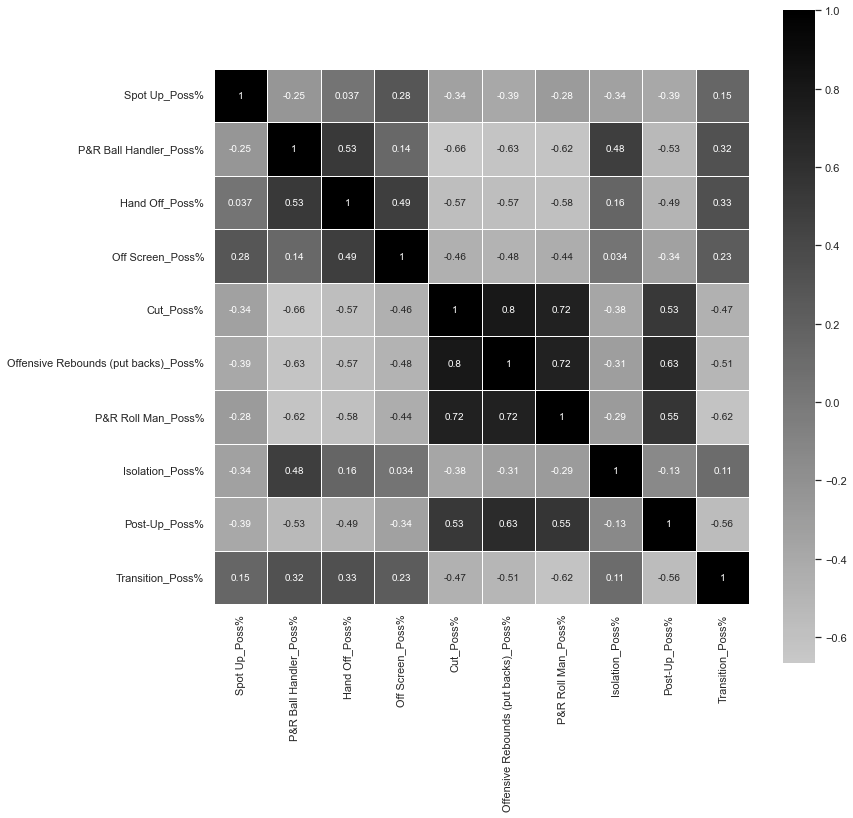

In [23]:
figsize(12, 8)
corr = df[poss_weights_cols].corr()
f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.light_palette('black', as_cmap=True)
sns.heatmap(corr, 
            cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5)

Show distributions of possession weights and effeiciency of each playtype

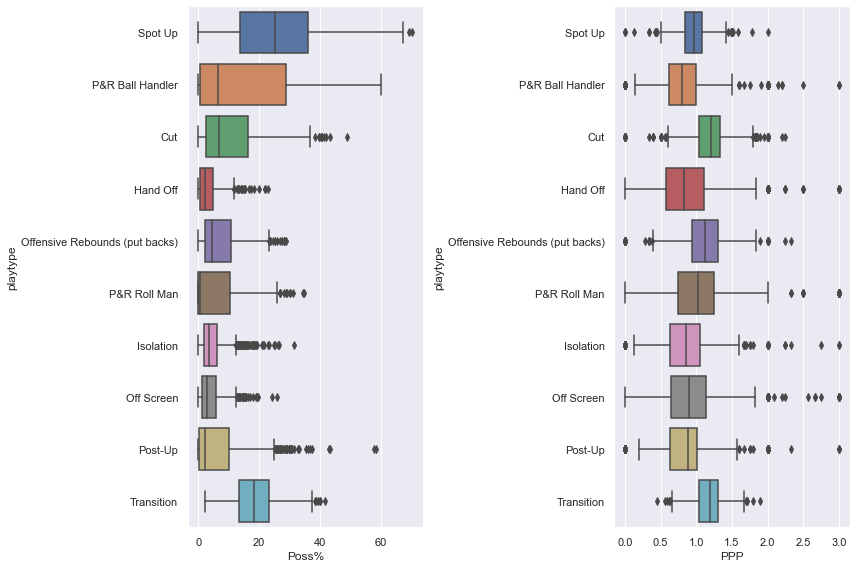

In [24]:
figsize(12, 8)
data = get_playtype_dist(df)
plt.subplot(1, 2, 1)
sns.boxplot(x="Poss%", y="playtype", data=data)
plt.subplot(1, 2, 2)
sns.boxplot(x="PPP", y="playtype", data=data)
plt.tight_layout()

Summary of distribution in playtype weights:
- Outliers exist 
    - Most of them are the result of skewed data
    - A few of them are creditted to players' own unique tendencies (ex. James Harden's iso game)
- There are some common playtypes
    - Spot Up
    - Transition
- Most are skewed
    - Big man
        - Cut
        - Offensive Rebounds
        - P&R Roll Man
        - Post-Up
    - Perimeter players
        - P&R Ball Handler
        - Hand Off
        - Off Screen
    - Star Privilege
        - Post-Up
        - Isolation
    
        

### Clustering

In [25]:
X = df[poss_weights_cols].copy()

Determine how many components reduce down to via PCA

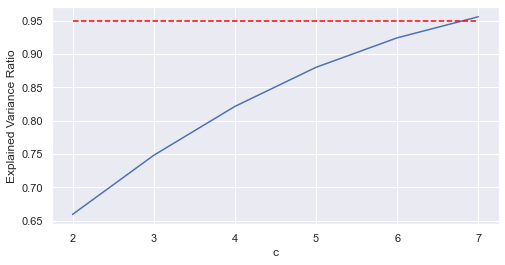

In [26]:
figsize(8, 4)
pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
plot_pca_explained_var(pre_pca_pipe.fit_transform(X))

Choose 7

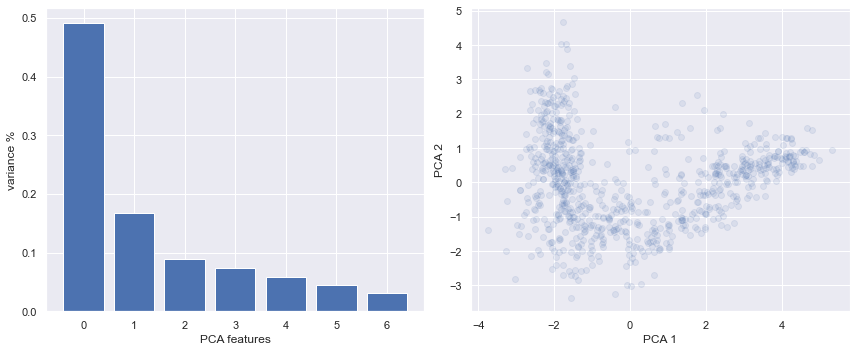

In [27]:
pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
pca = PCA(n_components=7)
pca.fit(pre_pca_pipe.fit_transform(X))
pca_components = pca.transform(pre_pca_pipe.fit_transform(X))

figsize(12, 5)
plt.subplot(1, 2, 1)
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(range(pca.n_components_))

plt.subplot(1, 2, 2)
plt.scatter(pca_components[:, 0], pca_components[:, 1], alpha=.1)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.tight_layout()

In [28]:
pre_cluster_scaler = StandardScaler()
X_transformed = pre_cluster_scaler.fit_transform(pca_components)

Determine # of clusters using silhouette score method

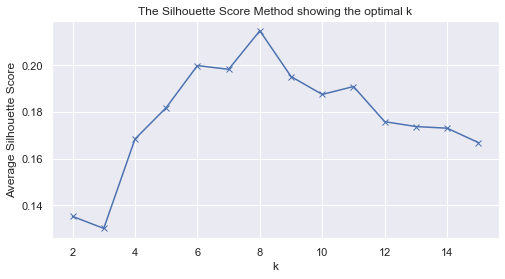

In [29]:
figsize(8, 4)
plot_silhouette_score(X_transformed)

Try 500 times to see if the clustering result stays robust. It turns out the algorithm delivers the same result 

In [30]:
# # Check stability
# check_cluster_robustness(X_transformed, 8, 500)

### Results

In [31]:
# Choose k = 8
sc = SpectralClustering(n_clusters=8, affinity='nearest_neighbors', random_state=42)
sc.fit(X_transformed)
df['player_cluster'] = sc.labels_
df['silhouette_coefficient'] = silhouette_samples(X_transformed, df['player_cluster'])
df.groupby('player_cluster').count()['Player']

player_cluster
0    140
1    135
2     84
3     71
4     21
5     83
6     95
7    165
Name: Player, dtype: int64

#### OBPM & Usage by Cluster

In [32]:
show_cluster_res(df, 'player_cluster')

,0,1,2,3,4,5,6,7
player_cluster,0,1,2,3,4,5,6,7
Spot Up_Poss%,39.94%,21.68%,31.92%,13.03%,27.37%,14.47%,11.49%,33.53%
P&R Ball Handler_Poss%,1.91%,39.36%,12.79%,0.66%,23.78%,24.02%,0.28%,13.54%
Hand Off_Poss%,1.01%,4.60%,5.01%,0.38%,15.08%,3.66%,0.32%,4.38%
Off Screen_Poss%,2.63%,3.61%,11.63%,1.40%,6.64%,4.34%,0.85%,4.16%
Cut_Poss%,13.45%,2.32%,5.72%,18.09%,3.34%,5.66%,27.09%,6.92%
Offensive Rebounds (put backs)_Poss%,8.22%,2.16%,3.43%,14.04%,1.94%,4.77%,16.82%,4.44%
P&R Roll Man_Poss%,9.09%,0.09%,1.68%,11.50%,0.24%,3.28%,18.70%,0.70%
Isolation_Poss%,2.86%,6.03%,4.06%,3.20%,3.11%,14.76%,1.82%,3.42%
Post-Up_Poss%,6.58%,0.59%,4.08%,26.84%,0.20%,5.56%,10.62%,1.86%


- Ballhandler: 5 & 1
- Big: 3 & 6
- Wing: 4 & 0 & 2 & 7

In [33]:
cluster_dict = {5: 'Ballhandler', 1: 'Ballhandler',
                3: 'Big', 6: 'Big',
                4: 'Wing', 0: 'Wing', 2: 'Wing', 7: 'Wing'}

In [34]:
cluster_dict_detail = {5: 'Ballhandler (Iso+PnR)', 1: 'Ballhandler (PnR)',
                       3: 'Big (Post Up+Roll)', 6: 'Big (Roll+Cut)',
                       0: 'Wing/Big (Spot Up+Cut+Transition)', 4: 'Wing (Hand Off+PnR)', 
                       2: 'Wing (Off Screen)', 7: 'Wing(Spot Up+Transition)'}

In [35]:
def color_cluster(val, cluster_dict=cluster_dict):
    if cluster_dict[val] == 'Ballhandler':
        return '#AB3B3A'
    elif cluster_dict[val] == 'Wing':
        return '#2E5C6E'
    elif cluster_dict[val] == 'Big':
        return '#F7D94C'

In [36]:
def color_cluster_pandas(val, cluster_dict=cluster_dict):
    if val in cluster_dict.keys():
        color = color_cluster(val, cluster_dict=cluster_dict)
    else:
        color = 'white'
    return f'background-color: {color}' 

In [37]:
show_cluster_res(df, 'player_cluster')\
.style.applymap(color_cluster_pandas)

,0,1,2,3,4,5,6,7
player_cluster,0,1,2,3,4,5,6,7
Spot Up_Poss%,39.94%,21.68%,31.92%,13.03%,27.37%,14.47%,11.49%,33.53%
P&R Ball Handler_Poss%,1.91%,39.36%,12.79%,0.66%,23.78%,24.02%,0.28%,13.54%
Hand Off_Poss%,1.01%,4.60%,5.01%,0.38%,15.08%,3.66%,0.32%,4.38%
Off Screen_Poss%,2.63%,3.61%,11.63%,1.40%,6.64%,4.34%,0.85%,4.16%
Cut_Poss%,13.45%,2.32%,5.72%,18.09%,3.34%,5.66%,27.09%,6.92%
Offensive Rebounds (put backs)_Poss%,8.22%,2.16%,3.43%,14.04%,1.94%,4.77%,16.82%,4.44%
P&R Roll Man_Poss%,9.09%,0.09%,1.68%,11.50%,0.24%,3.28%,18.70%,0.70%
Isolation_Poss%,2.86%,6.03%,4.06%,3.20%,3.11%,14.76%,1.82%,3.42%
Post-Up_Poss%,6.58%,0.59%,4.08%,26.84%,0.20%,5.56%,10.62%,1.86%


#### Possession Weights by Cluster

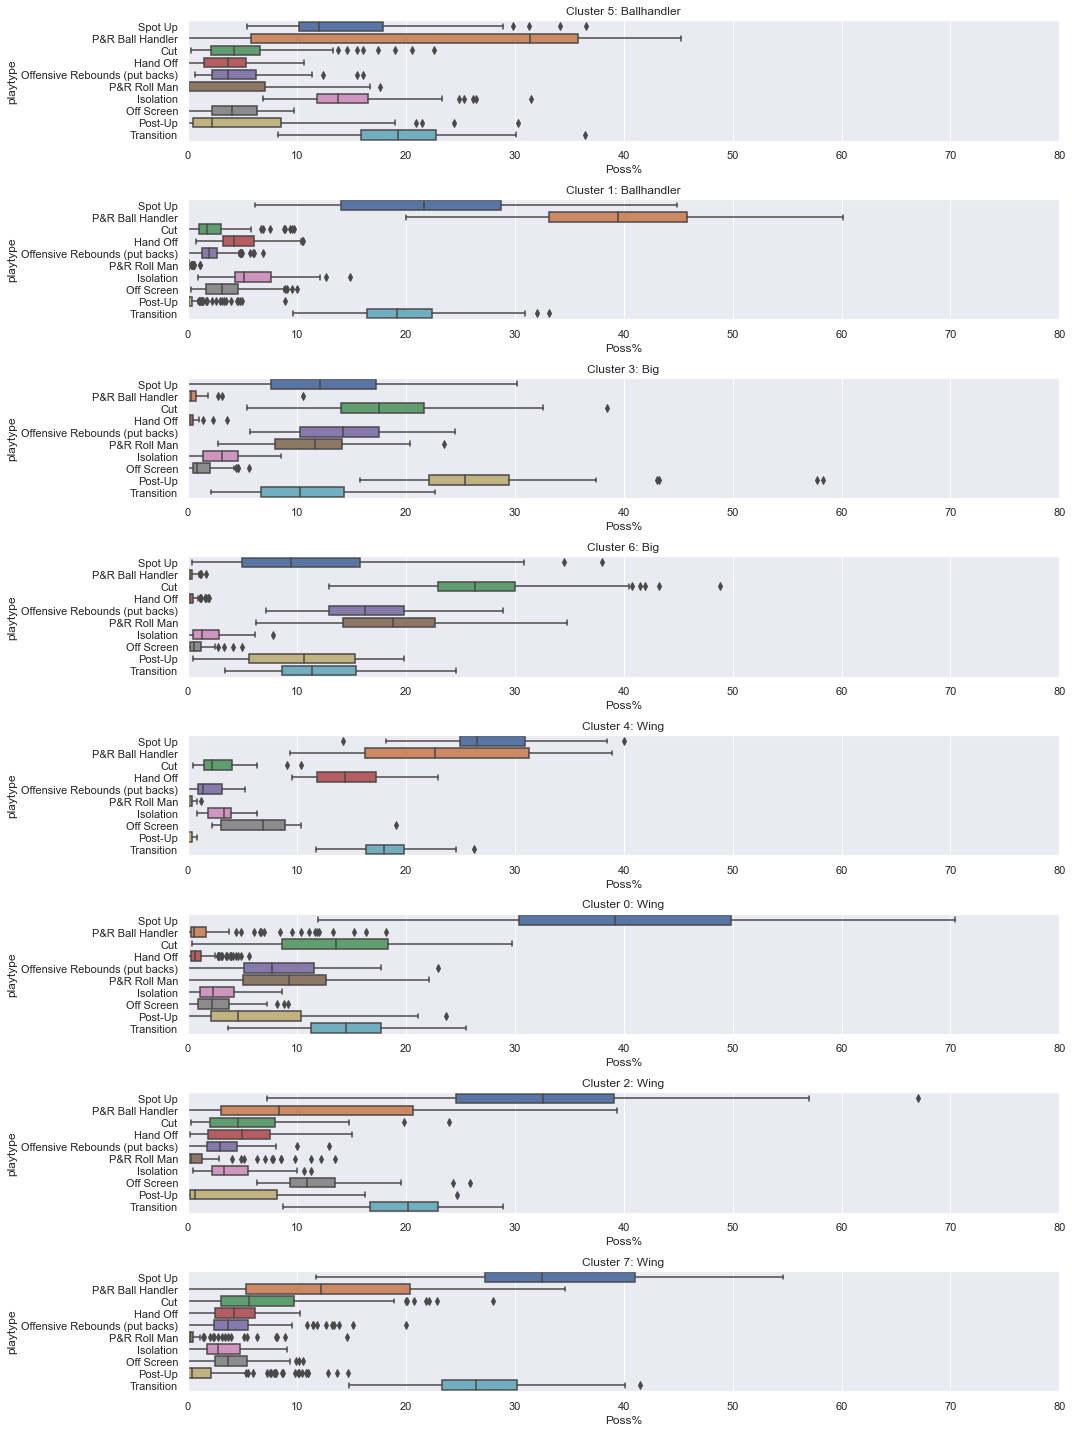

In [38]:
figsize(15, 20)
n_clusters = len(set(df['player_cluster']))
data_dict = {cluster: get_playtype_dist(df[df['player_cluster'] == cluster])
             for cluster in range(n_clusters)}

for idx, cluster in enumerate(list(cluster_dict.keys()), 1):
    data = get_playtype_dist(df[df['player_cluster'] == cluster])
    plt.subplot(n_clusters, 1, idx)
    sns.boxplot(x="Poss%", y="playtype", data=data_dict[cluster])
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}')
    plt.xlim(0, 80)

plt.tight_layout()

Summary of distribution in playtype weights:
- Good:
    - Cluster separate playtypes regarding pick & roll nicely
    - Cluster separate iso & post-up nicely
- Bad:
    - Skewed data & Outliers still exist

#### Observations

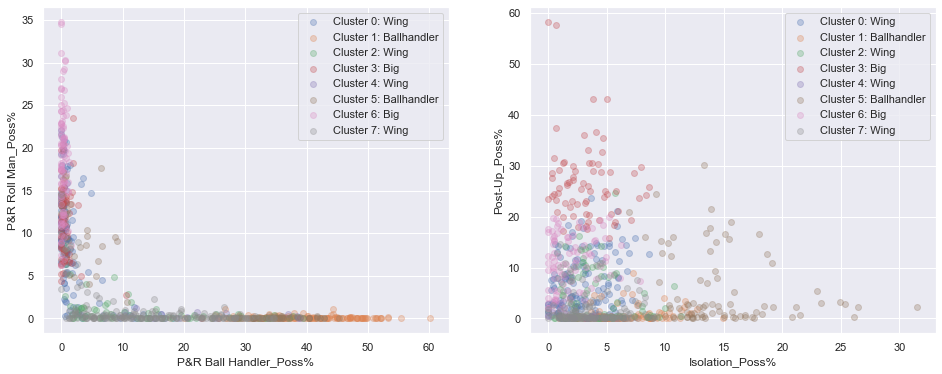

In [39]:
figsize(16, 6)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df, 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='P&R Roll Man_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df, 
                    cluster_col='player_cluster', 
                    col1='Isolation_Poss%', 
                    col2='Post-Up_Poss%',
                    cluster_dict=cluster_dict)

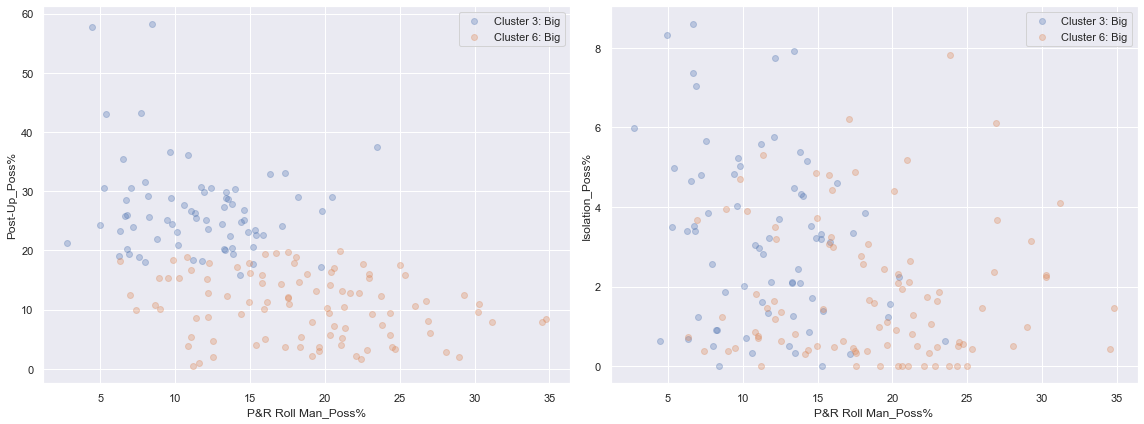

In [40]:
figsize(16, 6)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] == 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Roll Man_Poss%', 
                    col2='Post-Up_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] == 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Roll Man_Poss%', 
                    col2='Isolation_Poss%',
                    cluster_dict=cluster_dict)
plt.tight_layout()

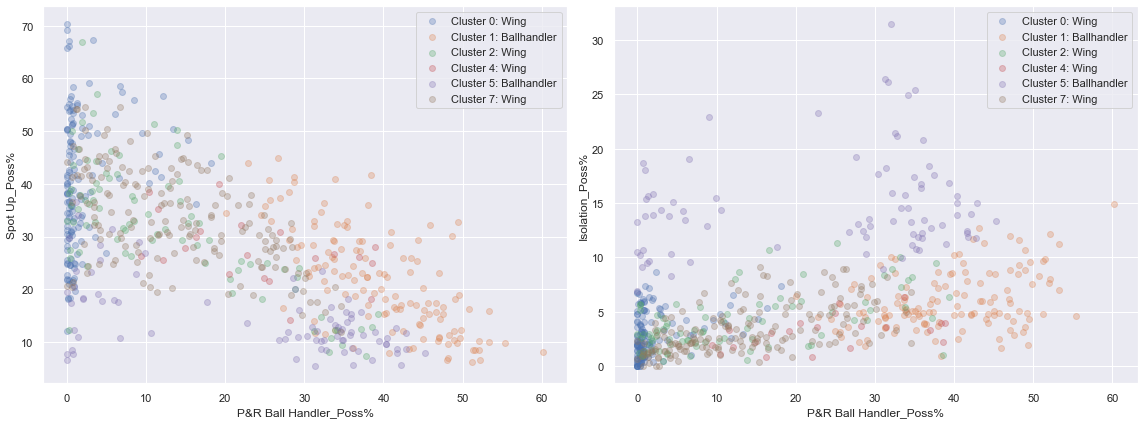

In [41]:
figsize(16, 6)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] != 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='Spot Up_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] != 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='Isolation_Poss%',
                    cluster_dict=cluster_dict)
plt.tight_layout()

#### Distributions

#### Ballhandler

In [42]:
c = 5
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 83


,Best 10 Players,Season,Team,Overall_PPP,Worst 10 Players,Season,Team,Overall_PPP
0,Andrew Nicholson,2020,Fujian SBS Xunxing Sturgeons,1.266,Terrence Jones,2017,Qingdao DoubleStar Eagles,0.866
1,Kenny Boynton,2018,old team do not use Shenzhen Leopards,1.239,Samad Bahrami,2017,Nanjing Tongxi Monkey Kings,0.892
2,Mike Harris,2017,Fujian SBS Xunxing Sturgeons,1.204,Tyrese Rice,2017,old team do not use Shenzhen Leopards,0.915
3,Von Wafer,2017,Jilin Northeast Tigers,1.194,Manny Harris,2020,Shandong Hi-Speed Golden Stars,0.920
4,Jared Sullinger,2018,old team do not use Shenzhen Leopards,1.180,Hangchu Liu,2017,Ningbo Bayi Rockets,0.923
5,Taylor Rochestie,2021,Tianjin Ronggang Gold Lions,1.180,Chasson Randle,2019,Tianjin Ronggang Gold Lions,0.937
6,Jamaal Franklin,2017,Sichuan Jinqiang Blue Whales,1.174,ThomasRobinson,2018,Beijing Beikong Fly Dragons,0.943
7,Troy Gillenwater,2021,Shandong Hi-Speed Golden Stars,1.171,Edwin Jackson,2017,Guangdong Dongguan Bank,0.944
8,Troy Gillenwater,2020,Shandong Hi-Speed Golden Stars,1.168,Song-wei Zhu,2021,Sichuan Jinqiang Blue Whales,0.946
9,Nick Minnerath,2017,Shanghai Bilibili Sharks,1.160,Stephon Marbury,2017,Beijing Beikong Fly Dragons,0.951


In [43]:
c = 1
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 135


,Best 10 Players,Season,Team,Overall_PPP,Worst 10 Players,Season,Team,Overall_PPP
0,Eugene Jeter,2019,Fujian SBS Xunxing Sturgeons,1.206,Dehao Yu,2021,Xinjiang Tianshan R-C Bank Flying Tigers,0.631
1,Pierre Jackson,2018,Beijing Beikong Fly Dragons,1.196,Rongqi Huang,2018,Sichuan Jinqiang Blue Whales,0.635
2,MarShon Brooks,2020,Guangdong Dongguan Bank,1.193,Rong-qi Huang,2021,Jiangsu Dragons Knetier,0.655
3,Aaron Jackson,2018,Beijing Shougang Ducks,1.165,Xiaoyu Liu,2017,Beijing Shougang Ducks,0.661
4,Dallas Moore,2020,Guangzhou Securities Long-Lions,1.163,Yiyang Li,2021,Fujian SBS Xunxing Sturgeons,0.673
5,Jonathan Gibson,2021,Beijing Shougang Ducks,1.155,Mengchen Mo,2019,Sichuan Jinqiang Blue Whales,0.699
6,Jonathan Gibson,2020,Beijing Shougang Ducks,1.122,Yi Shi,2019,Tianjin Ronggang Gold Lions,0.700
7,Ty Lawson,2019,Fujian SBS Xunxing Sturgeons,1.103,Xiaoyu Liu,2019,Beijing Shougang Ducks,0.707
8,Aaron Jackson,2017,Beijing Shougang Ducks,1.099,Xiran Zhang,2020,Jiangsu Dragons Knetier,0.711
9,Sonny Weems,2018,Guangdong Dongguan Bank,1.090,Dehao Yu,2020,Xinjiang Tianshan R-C Bank Flying Tigers,0.729


#### Big

In [44]:
c = 3
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 71


,Best 10 Players,Season,Team,Overall_PPP,Worst 10 Players,Season,Team,Overall_PPP
0,ArnettMoultrie,2021,Xinjiang Tianshan R-C Bank Flying Tigers,1.290,Zhonghao Xu,2019,Ningbo Bayi Rockets,0.692
1,Jarnell Stokes,2018,Xinjiang Tianshan R-C Bank Flying Tigers,1.246,Zhonghao Xu,2017,Ningbo Bayi Rockets,0.704
2,Elijah Holman,2017,Tianjin Ronggang Gold Lions,1.228,Yuanyu Li,2020,Sichuan Jinqiang Blue Whales,0.793
3,Andrew Hansbrough,2019,Sichuan Jinqiang Blue Whales,1.214,Hamed Haddadi,2021,Sichuan Jinqiang Blue Whales,0.796
4,Carl Landry,2017,Jilin Northeast Tigers,1.205,Zhonghao Xu,2018,Ningbo Bayi Rockets,0.820
5,Zheng Wang,2018,Beijing Beikong Fly Dragons,1.202,Wan Shengwei,2020,Nanjing Tongxi Monkey Kings,0.860
6,Dakari Johnson,2019,Qingdao DoubleStar Eagles,1.201,Hamed Haddadi,2020,Sichuan Jinqiang Blue Whales,0.900
7,Dejun Han,2020,Liaoning Scale Industry Flying Leopards,1.198,Hamed Haddadi,2018,Xinjiang Tianshan R-C Bank Flying Tigers,0.903
8,Andrew Nicholson,2018,Fujian SBS Xunxing Sturgeons,1.195,Hamed Haddadi,2019,Nanjing Tongxi Monkey Kings,0.907
9,Arnett Nathaniel Moultrie,2020,Nanjing Tongxi Monkey Kings,1.184,Donatas Motiejunas,2019,Shanghai Bilibili Sharks,0.909


In [45]:
c = 6
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 95


,Best 10 Players,Season,Team,Overall_PPP,Worst 10 Players,Season,Team,Overall_PPP
0,Jinqiu Hu,2021,Zhejiang Guangsha Lions,1.352,Hao Zhang,2020,Guangdong Dongguan Bank,0.819
1,Jinqiu Hu,2018,Zhejiang Guangsha Lions,1.295,Jinxiao Li,2020,Zhejiang Guangsha Lions,0.842
2,Jinqiu Hu,2020,Zhejiang Guangsha Lions,1.287,Yuxuan Liu,2020,Jiangsu Dragons Knetier,0.874
3,Jinqiu Hu,2017,Zhejiang Guangsha Lions,1.265,Yuanyu Li,2021,Qingdao DoubleStar Eagles,0.878
4,Tyler Hansbrough,2017,Guangzhou Securities Long-Lions,1.233,Tong-Lin Sun,2020,Beijing Beikong Fly Dragons,0.884
5,Jinqiu Hu,2019,Zhejiang Guangsha Lions,1.220,Dayu Zhang,2018,Zhejiang Chouzhou Bank Golden Bulls,0.886
6,Zijie Shen,2021,Shenzhen Aviators,1.219,Xierzhati Saimati,2020,Xinjiang Tianshan R-C Bank Flying Tigers,0.899
7,Hanlin Tao,2017,Shandong Hi-Speed Golden Stars,1.191,Shaojie Wang,2021,Beijing Beikong Fly Dragons,0.901
8,Kai Guo,2018,Guangzhou Securities Long-Lions,1.188,Dayu Zhang,2017,Zhejiang Chouzhou Bank Golden Bulls,0.908
9,Justin Hamilton,2018,Beijing Shougang Ducks,1.181,Wei Su,2020,Guangdong Dongguan Bank,0.915


#### Wing

In [46]:
c = 4
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 21


,Best 10 Players,Season,Team,Overall_PPP,Worst 10 Players,Season,Team,Overall_PPP
0,Shuai Yuan,2021,Shanxi Fenjiu Brave Dragons,1.182,No Ta,2020,Tianjin Ronggang Gold Lions,0.623
1,TaiLong Zhao,2021,Qingdao DoubleStar Eagles,1.182,Weihan Lin,2021,Qingdao DoubleStar Eagles,0.727
2,Shuai Yuan,2020,Shanxi Fenjiu Brave Dragons,1.112,Junfeng Zhao,2021,Ningbo Bayi Rockets,0.742
3,Jonathan Gibson,2019,Jiangsu Dragons Knetier,1.066,Ning Zhang,2020,Shanxi Fenjiu Brave Dragons,0.841
4,Meng Lei,2019,Ningbo Bayi Rockets,0.989,Borun Li,2021,Ningbo Bayi Rockets,0.843
5,Shuo Han,2020,Sichuan Jinqiang Blue Whales,0.980,Hongfei Shi,2019,Jiangsu Dragons Knetier,0.857
6,Delong Han,2021,Ningbo Bayi Rockets,0.964,Da Meng,2017,Sichuan Jinqiang Blue Whales,0.897
7,Meng Lei,2017,Ningbo Bayi Rockets,0.962,Wei Liu,2018,Shanghai Bilibili Sharks,0.906
8,Shuo Han,2021,Sichuan Jinqiang Blue Whales,0.955,Feng Xin,2020,Zhejiang Guangsha Lions,0.913
9,Da Meng,2019,Sichuan Jinqiang Blue Whales,0.932,Meng Lei,2018,Ningbo Bayi Rockets,0.917


In [47]:
c = 0
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 140


,Best 10 Players,Season,Team,Overall_PPP,Worst 10 Players,Season,Team,Overall_PPP
0,Yanxi Zhu,2018,Beijing Shougang Ducks,1.248,Wei Liu,2019,Jiangsu Dragons Knetier,0.742
1,Yanxi Zhu,2017,Beijing Shougang Ducks,1.233,Siyao Sun,2020,Nanjing Tongxi Monkey Kings,0.747
2,Zhun Zheng,2019,Guangzhou Securities Long-Lions,1.210,Cheng Zhong,2019,Jilin Northeast Tigers,0.749
3,Jianlian Yi,2018,Guangdong Dongguan Bank,1.207,Liang Cai,2019,Shanghai Bilibili Sharks,0.752
4,Zhun Zheng,2020,Guangzhou Securities Long-Lions,1.198,Ruheng Wang,2017,Shandong Hi-Speed Golden Stars,0.763
5,Zhun Zheng,2021,Guangzhou Securities Long-Lions,1.184,Ke Wu,2017,Shandong Hi-Speed Golden Stars,0.790
6,Junlong Zhu,2021,Zhejiang Guangsha Lions,1.174,Xiaoxu Li,2017,Liaoning Scale Industry Flying Leopards,0.797
7,TJ Leaf,2021,Guangzhou Securities Long-Lions,1.169,Ying-lun Yin,2020,Qingdao DoubleStar Eagles,0.802
8,Miroslav Raduljica,2019,Jiangsu Dragons Knetier,1.165,Cheng Zhong,2020,Jilin Northeast Tigers,0.805
9,Jiaren Zhao,2021,Zhejiang Guangsha Lions,1.163,Xiaoxu Li,2019,Liaoning Scale Industry Flying Leopards,0.811


In [48]:
c = 2
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 84


,Best 10 Players,Season,Team,Overall_PPP,Worst 10 Players,Season,Team,Overall_PPP
0,Tailong Zhao,2017,Fujian SBS Xunxing Sturgeons,1.249,Yue Sun,2019,Beijing Beikong Fly Dragons,0.845
1,Gen Li,2017,Xinjiang Tianshan R-C Bank Flying Tigers,1.214,Rongpei Li,2017,Tianjin Ronggang Gold Lions,0.859
2,Shuai Yuan,2019,Shanxi Fenjiu Brave Dragons,1.185,Biao Zhang,2019,Jilin Northeast Tigers,0.863
3,Jinglong Li,2018,Zhejiang Guangsha Lions,1.171,Shirelijian Muxtar,2021,Nanjing Tongxi Monkey Kings,0.870
4,O. J. Mayo,2020,Liaoning Scale Industry Flying Leopards,1.166,Muhtar Xirelijiang,2019,Xinjiang Tianshan R-C Bank Flying Tigers,0.877
5,MingchenChong,2020,Liaoning Scale Industry Flying Leopards,1.146,Chen Chen,2021,Sichuan Jinqiang Blue Whales,0.885
6,Lester Hudson,2017,Liaoning Scale Industry Flying Leopards,1.137,Li Hondhan,2021,Sichuan Jinqiang Blue Whales,0.887
7,Jimmer Fredette,2018,Shanghai Bilibili Sharks,1.136,Huaibo Dai,2021,Jilin Northeast Tigers,0.900
8,QuAn Gu,2021,Shenzhen Aviators,1.119,Zhiqiang Xing,2019,Shanxi Fenjiu Brave Dragons,0.902
9,Junwei Ren,2019,Shanxi Fenjiu Brave Dragons,1.110,Xiaochuan Zhai,2021,Beijing Shougang Ducks,0.903


In [49]:
c = 7
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 165


,Best 10 Players,Season,Team,Overall_PPP,Worst 10 Players,Season,Team,Overall_PPP
0,Yuxing Jiang,2019,Jilin Northeast Tigers,1.207,Sidikejiang Kamiran,2019,Fujian SBS Xunxing Sturgeons,0.676
1,Kyle Fogg,2021,Liaoning Scale Industry Flying Leopards,1.198,Hong Wang,2019,Jiangsu Dragons Knetier,0.698
2,O. J. Mayo,2019,Liaoning Scale Industry Flying Leopards,1.196,Zhennian Zuo,2019,Sichuan Jinqiang Blue Whales,0.750
3,Runwang Du,2019,Guangdong Dongguan Bank,1.193,Xin Feng,2017,Nanjing Tongxi Monkey Kings,0.758
4,Abudushalamu Abudurexiti,2018,Xinjiang Tianshan R-C Bank Flying Tigers,1.187,Zilu Wang,2018,Zhejiang Chouzhou Bank Golden Bulls,0.771
5,Runwang Du,2020,Guangdong Dongguan Bank,1.183,Yang Haozhe,2020,Nanjing Tongxi Monkey Kings,0.772
6,Ty Lawson,2017,Shandong Hi-Speed Golden Stars,1.174,Jinming Cui,2017,Jilin Northeast Tigers,0.786
7,Mingxuan Hu,2019,Guangdong Dongguan Bank,1.162,Zirui Wang,2019,Beijing Beikong Fly Dragons,0.789
8,Xinkai Wang,2019,Guangdong Dongguan Bank,1.153,Rongqi Huang,2017,Sichuan Jinqiang Blue Whales,0.790
9,Wenbo Lu,2020,Zhejiang Chouzhou Bank Golden Bulls,1.150,Yuheng Tian,2020,Guangzhou Securities Long-Lions,0.792


#### Edge Cases

In [50]:
temp = df.groupby('Player')['player_cluster'].apply(list).reset_index()
temp['player_cluster_adj'] = temp['player_cluster'].apply(lambda x: [cluster_dict[s] 
                                                                     for s in x])\
                                                   .apply(set)
temp['player_cluster'] = temp['player_cluster'].apply(set)
temp['n_cluster'] = temp['player_cluster_adj'].apply(len)
temp[temp['n_cluster'] == 3]

,Player,player_cluster,player_cluster_adj,n_cluster
125,Jianlian Yi,"{0, 5, 6}","{Ballhandler, Wing, Big}",3


In [51]:
temp[(temp['n_cluster'] == 2) & (temp['player_cluster_adj'] == set(['Ballhandler', 'Big']))]

,Player,player_cluster,player_cluster_adj,n_cluster
8,Andrew Nicholson,"{3, 5}","{Ballhandler, Big}",2


### Visualization via TSNE

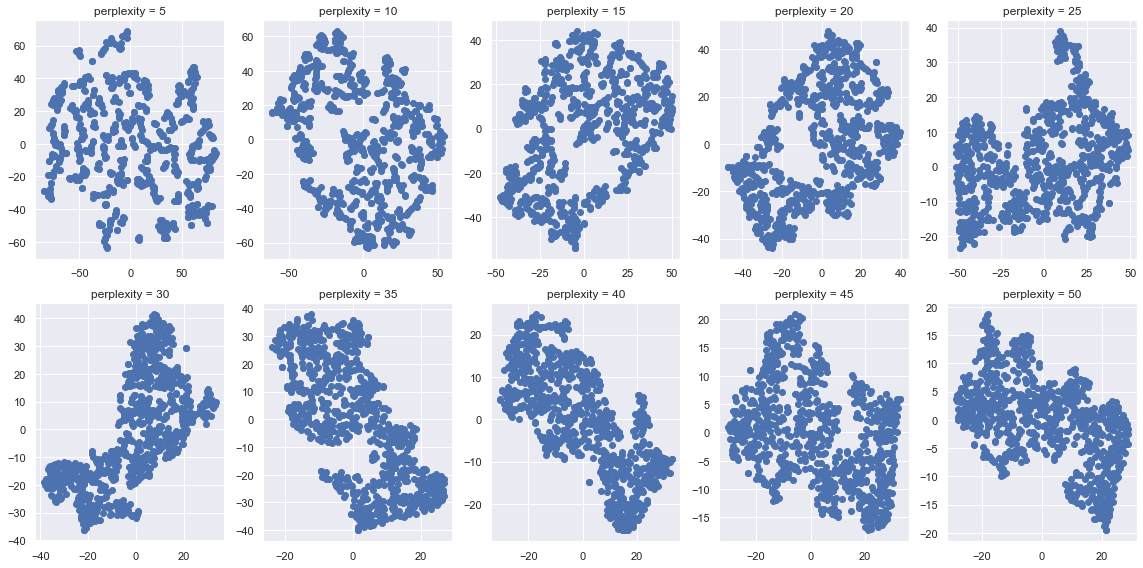

In [52]:
figsize(16, 8)
for i in list(range(1, 11)):
    plt.subplot(2, 5, i)
    perplexity = 5 * i
    tsne = TSNE(perplexity=perplexity, random_state=0)
    X_tsne = tsne.fit_transform(X_transformed)
    plt.scatter(X_tsne[:,0], X_tsne[:, 1])
    plt.title(f'perplexity = {perplexity}')
plt.tight_layout()

In [53]:
tsne = TSNE(perplexity=25, random_state=0)
X_tsne = tsne.fit_transform(X_transformed)

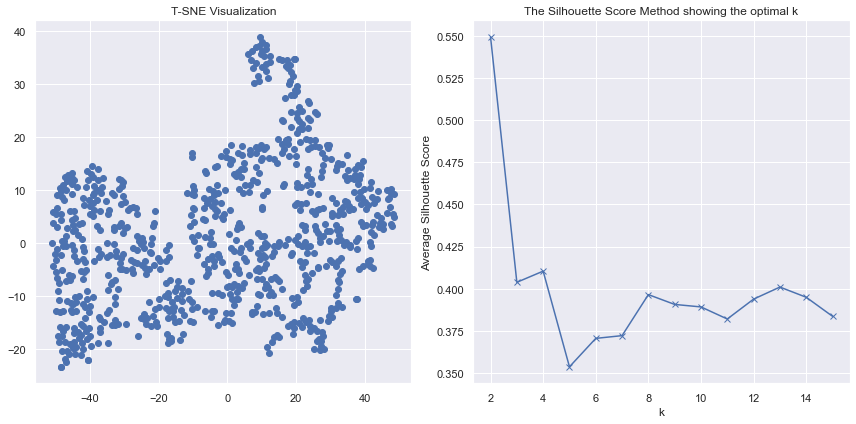

In [54]:
figsize(12, 6)
plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1])
plt.title('T-SNE Visualization')
plt.subplot(1, 2, 2)
plot_silhouette_score(X_tsne)
plt.tight_layout()

In [55]:
df_tsne = df.copy()
# Choose k = 4
sc_tsne = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', random_state=42)
sc_tsne.fit(X_tsne)
df_tsne['cluster_label_tsne'] = sc_tsne.labels_

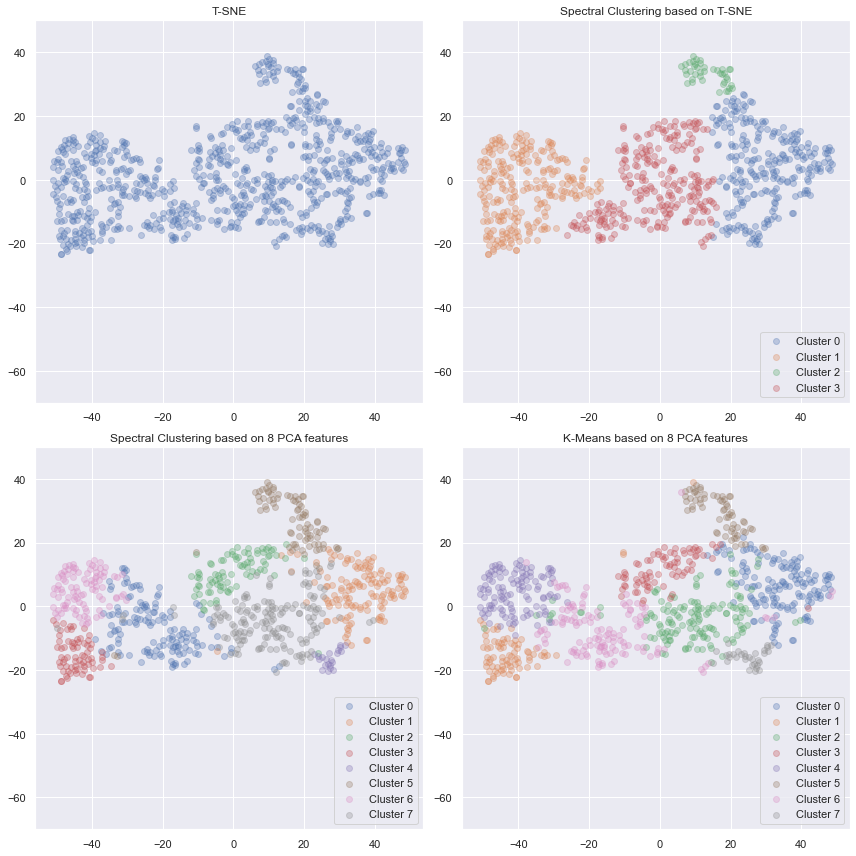

In [56]:
figsize(12, 12)

plt.subplot(2, 2, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1], alpha=0.3)
plt.title('T-SNE')
plt.ylim(-70, 50)

plt.subplot(2, 2, 2)
for i in range(4):
    cluster_cond = df_tsne['cluster_label_tsne'] == i
    cluster_index = df_tsne[cluster_cond].index
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc='lower right')
plt.title('Spectral Clustering based on T-SNE')
plt.ylim(-70, 50)

n_clusters = 8

plt.subplot(2, 2, 3)
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc='lower right')
plt.title(f'Spectral Clustering based on {n_clusters} PCA features')
plt.ylim(-70, 50)


plt.subplot(2, 2, 4)
km = KMeans(n_clusters=n_clusters, random_state=42)
labels = km.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc='lower right')
plt.title(f'K-Means based on {n_clusters} PCA features')
plt.ylim(-70, 50)

plt.tight_layout()

(-70.0, 50.0)

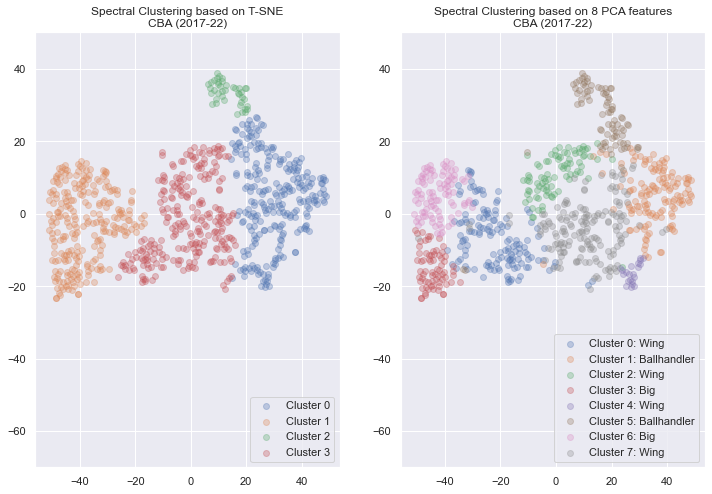

In [57]:
figsize(12, 8)

league = 'CBA (2017-22)'

plt.subplot(1, 2, 1)
for i in range(4):
    cluster_cond = df_tsne['cluster_label_tsne'] == i
    cluster_index = df_tsne[cluster_cond].index
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc='lower right')
plt.title(f'Spectral Clustering based on T-SNE\n{league}')
plt.ylim(-70, 50)

n_clusters = 8

plt.subplot(1, 2, 2)
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
plt.legend(loc='lower right')
plt.title(f'Spectral Clustering based on {n_clusters} PCA features\n{league}')
plt.ylim(-70, 50)

## Add Feature

In [58]:
overseas_players = ['Robert Golden', 'J.J. Hickson', 'Ty Lawson', 'MarcusHunt', 'Brandon Bass',
                    'Ike Diogu', 'JamesMays', 'Jarel Martin', 'Cole Aldrich', 'Isaac Haas',
                    'Askia Booker', 'ArnettMoultrie', 'Jarrod Jones', 'Pierre Jackson', 'Aaron Jackson',
                    'Jimmer Fredette', 'Ricky Ledo', 'Stephon Marbury', 'Keifer Sykes', 'Vladimir Stimac',
                    'Eric Morland', 'Donatas Motiejunas', 'Darius Adams', 'Kenny Boynton', 'Terrence Jones',
                    'SylvanLandsberg', 'Guerschon Yabusele', 'ClarenceTrotter III', 'Taylor Rochestie', 'Mike Harris',
                    'Jahil Okafor', 'NickRakocevic', 'Brandon Paul', 'James Mays', 'Jeremy Pargo',
                    'Lance Stephenson', 'Isaiah Austin', 'Andrew Harrison', 'Justin Hamilton', 'Troy Gillenwater',
                    'Joseph Young', 'Luis Scola', 'Kenny Burton', 'Shavlik Randolph', 'Russ Smith',
                    'Sonny Weems', 'Shabazz Muhammad', 'Tyler Hansbrough', 'Jarnell Stokes', 'Dallas Moore',
                    'Arnett Nathaniel Moultrie', 'Kay Felder', 'Dezmine Wells', 'Dominique Jones', 'MarkoTodorovic',
                    'Marcus Denmon', 'Carl Landry', 'Kay Feld', 'Elijah Holman', 'Semaj Christon',
                    'Lester Hudson', 'Josh Adams', 'Tyrese Rice', 'Hamed Haddadi', 'Marcus Georges-Hunt',
                    'Eric Moreland', 'IsaacHaas', 'Mo Speights', 'Jeremy Lin', 'Ekpe Udoh',
                    'Jonathan Simmons', 'Zaid Abbas', 'O. J. Mayo', 'Nick Minnerath', 'Jason Thompson',
                    'Sylven Landesberg', 'Wells Dezmine', 'TJ Leaf', 'Jamaal Franklin', 'Nate Mason',
                    'Dez Wells', "D'MontreEdwards", 'Ioannis Bourousis', 'Dmontre Edwards', 'Sani Sakakini',
                    'Derrick Williams', 'Dakari Johnson', 'Antonio Blakeney', 'Malcolm Delaney', 'Bobby Brown',
                    'Eric Green', 'Keith Langford', 'Sean Hill', 'Andre Blatche', 'Edwin Jackson',
                    'Donald Sloan', 'Ray McCallum', 'Samad Bahrami', 'Manny Harris', 'Chasson Randle',
                    'Eugene Jeter', 'Andrew Nicholson', 'Andrew Goudelock', 'Willie Warren', 'Courtney Fortson',
                    'Kyle Fogg', 'Jamal Franklin', 'Maciej Lampe', 'ClarenceTrotter', 'ThomasRobinson',
                    'Jonathan Gibson', 'Von Wafer', 'MarShon Brooks', 'Noah Vonleh', 'Brandon Jennings',
                    'Dwight Buycks', 'Jared Sullinger', 'Andrew Hansbrough', 'Miroslav Raduljica']

In [59]:
df['is_overseas'] = df['Player'].apply(lambda x: 1 if x in overseas_players else 0)

In [74]:
df[(df['player_cluster'].isin([5])) & (df['is_overseas'] == 0)]\
[['Player', 'Season', 'Team', 'player_cluster']]

,Player,Season,Team,player_cluster
36,Hangchu Liu,2017,Ningbo Bayi Rockets,5
109,Jianlian Yi,2017,Guangdong Dongguan Bank,5
684,Biao Zhang,2021,Ningbo Bayi Rockets,5
746,Song-wei Zhu,2021,Sichuan Jinqiang Blue Whales,5


In [60]:
cuba_players = ['Baiqing Zhao', 'Yiyang Li', 'Dianliang Zhang', 'Dong Liu',
                'Zhenxiang Na', #2021
                'Mingzhen Zhu', 'Song-wei Zhu', 'Qi-long Zheng', 'Ning Zhang',
                'Yang Haozhe', #2020
                'Shaojie Wang', 'Tangwen Yuan', 'Siyu He', 'Ruize Wang', #2019
                'Wan Shengwei', #2018
                'Wenhan Qiao', #2017
                'Kai Guo', 'Hong Wang' #2016
               ]

In [61]:
df['is_cuba'] = df['Player'].apply(lambda x: 1 if x in cuba_players else 0)

## Data Viz (CUBA)

In [62]:
temp = df.groupby(['player_cluster']).count()[['Player']].reset_index()
temp['cluster_role'] = temp['player_cluster'].map(cluster_dict)
temp['cluster_role_detail'] = temp['player_cluster'].map(cluster_dict_detail)
for t in ['overseas', 'cuba']:
    temp = temp.merge(df.groupby(['player_cluster'])[[f'is_{t}']].sum().reset_index())
    temp[f'is_{t}%'] = temp[f'is_{t}'] / temp['Player']
temp.sort_values('is_overseas%', ascending=False)

,player_cluster,Player,cluster_role,cluster_role_detail,is_overseas,is_overseas%,is_cuba,is_cuba%
5,5,83,Ballhandler,Ballhandler (Iso+PnR),79,0.951807,1,0.012048
3,3,71,Big,Big (Post Up+Roll),43,0.605634,2,0.028169
1,1,135,Ballhandler,Ballhandler (PnR),39,0.288889,2,0.014815
2,2,84,Wing,Wing (Off Screen),15,0.178571,0,0.000000
6,6,95,Big,Big (Roll+Cut),12,0.126316,4,0.042105
7,7,165,Wing,Wing(Spot Up+Transition),11,0.066667,8,0.048485
0,0,140,Wing,Wing/Big (Spot Up+Cut+Transition),9,0.064286,10,0.071429
4,4,21,Wing,Wing (Hand Off+PnR),1,0.047619,1,0.047619


In [63]:
df[(df['player_cluster'].isin([3, 5])) & (df['is_cuba'] == 1)]\
[['Player', 'Season', 'Team', 'player_cluster']]

,Player,Season,Team,player_cluster
550,Wan Shengwei,2020,Nanjing Tongxi Monkey Kings,3
746,Song-wei Zhu,2021,Sichuan Jinqiang Blue Whales,5
747,Dianliang Zhang,2021,Sichuan Jinqiang Blue Whales,3


In [64]:
labels = df['player_cluster'].values

In [65]:
def plot_players(lookup_idx, labels=labels, X_tsne=X_tsne, df=df, 
                 cluster_dict_detail=cluster_dict_detail):
    n_clusters = len(set(labels))
    for i in range(n_clusters):
        cluster_index = [j for j in range(len(labels)) if labels[j] == i]
        plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], 
                    label=f'Cluster {i}: {cluster_dict_detail[i]}', alpha=0.3)
        plt.ylim(-70, 50)
    plt.legend(loc='lower right')
    plt.title(f'TSNE Visualization (Spectral Clustering based on {n_clusters} PCA features)')
    for idx in lookup_idx:
        player_coord = X_tsne[idx]
        plt.scatter(player_coord[0], player_coord[1], marker='x', color='black')
        plt.annotate(f"{df.loc[idx]['Player']} {df.loc[idx]['Season']} {df.loc[idx]['Team'].split(' ')[0]}", 
                     player_coord, alpha=0.6)
        plt.ylim(-70, 50)

In [66]:
lookup_idx = df[(df['Player'].isin(cuba_players)) &
                (df['Season'] == 2021)].index

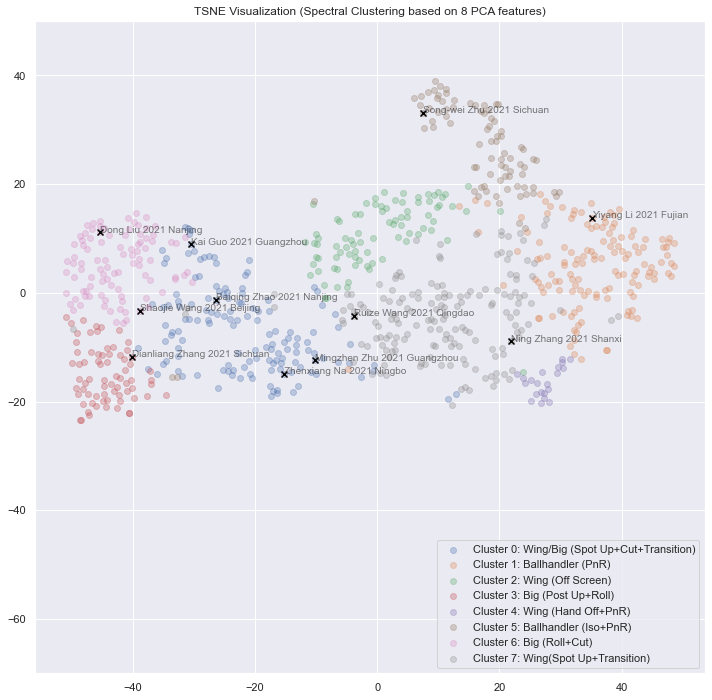

In [67]:
figsize(12, 12)
plot_players(lookup_idx)

## Save Models

In [68]:
# df.to_csv('cba_cleaned.csv', index=False)

In [69]:
# cba_clustering_models = {'pre_pca_pipe': pre_pca_pipe,
#                          'pca': pca,
#                          'pre_cluster_scaler': pre_cluster_scaler,
#                          'cluster_dict': cluster_dict}
# dump_pickle(cba_clustering_models, 'cba_clustering_models')

In [70]:
# cluster_map_km_to_sc = {0: 3, 
#                         1: 1, 
#                         2: 2, 
#                         3: 5, 
#                         4: 0, 
#                         5: 4, 
#                         6: 6}
# cba_clustering_models_km = {'pre_pca_pipe': pre_pca_pipe,
#                             'pca': pca,
#                             'pre_cluster_scaler': pre_cluster_scaler,
#                             'cluster_map_to_spectral_clustering': cluster_map_km_to_sc,
#                             'km': km}
# dump_pickle(cba_clustering_models_km, 'cba_clustering_models_km')